Graph before modify


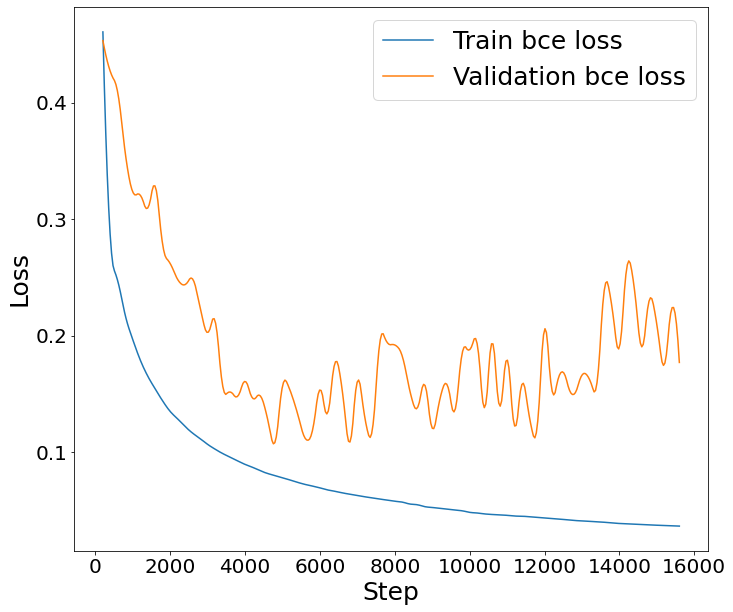

In [17]:
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option("display.max_columns", None)

import numpy as np
import matplotlib.pyplot as plt
import math

import os.path as osp
import csv
from typing import List

from torch import AnyType

def read_file(csv_file: str):
    """ 
    0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
    epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    epoch, Train loss, Train accuracy, Val loss,  Val accuracy,  Val real pre,  Val real rec,  Val real F1-Score,  Val fake pre,  Val fake rec,  Val fake F1-Score,  Val micro pre,  Val micro rec,  Val micro F1-Score, Val macro pre,  Val macro rec,  Val macro F1-Score
    Args:
        csv_file (str): path to file
    """
    global NUM_INFO
    global to_step
    result = [[] for _ in range(NUM_INFO)]
    # Read file
    file = open(csv_file)
    csvreader = csv.reader(file)
    # Get result:
    for idx, row in enumerate(csvreader):
        if idx == 0:
            continue
        if to_step is not None and idx > to_step:
            break
        for i in range(NUM_INFO):
            if i == 0:
                result[0].append(int(row[0]))
                continue
            result[i].append(float(row[i]))
    
    if 'test' in osp.basename(csv_file):
        phase = "Test"
    else:
        phase = "Validation"
        
    if 'epoch' in csv_file:
        iter_method = 'Epoch'
    else:
        iter_method = 'Step'
    
    results = []
    for i, r in enumerate(result):
        results.append(np.array(r, dtype=np.int32 if i == 0 else np.float32))
    return results, phase, iter_method

def number_of_step(csv_file: str):
    df = pd.read_csv(csv_file)
    return df.shape[0]

def plot_loss_and_accuracy(iter_loop: List[int], iter_method: str, values: List[List[float]], phase="Val", pairwise=False):
    """ values: [train_loss, train_acc, val_loss, val_acc]
    if pairwise: [train_contrastive_loss, train_bce_loss, train_total_loss, train_acc, val_contrastive, val_bce, val_total, val_accu]
    """
    global figsize_lossacc, fig_saved_path, saved
    if pairwise:
        plt.figure(figsize=figsize_lossacc)
        # plt.subplot(2, 2, 1)
        # plt.plot(iter_loop, values[0], label="Train contrastive loss")
        # plt.plot(iter_loop, values[4], label=phase + " contrastive loss")
        # plt.legend()
        # plt.title("Contrastive Loss")
        # plt.xlabel('Step')
        # plt.ylabel('Loss')
        if 'loss' in saved:
            plt.subplot(1, 2, 1)
            plt.plot(iter_loop, values[1], label="Train bce loss")
            plt.plot(iter_loop, values[5], label=phase + " bce loss")
            plt.legend(fontsize=25)
            # plt.title("BCE Loss", fontsize=30)
            plt.xlabel('Step', fontsize=25)
            plt.ylabel('Loss', fontsize=25)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
        # plt.xticks([i for i in range(1, len(epochs)+1)])
        # plt.yticks([0.1*i for i in range(1, 16)])
        
        # plt.subplot(2, 2, 3)
        # plt.plot(iter_loop, values[2], label="Train total loss")
        # plt.plot(iter_loop, values[6], label=phase + " total loss")
        # plt.legend()
        # plt.title("Total Loss")
        # plt.xlabel('Step')
        # plt.ylabel('Loss')
        if 'acc' in saved:
            plt.subplot(1, 2, 2)
            plt.plot(iter_loop, values[3], label="Train accuracy")
            plt.plot(iter_loop, values[7], label=phase + " accuracy")
            plt.legend(fontsize=20)
            plt.title("Accuracy")
            plt.xlabel('Step', fontsize=18)
            plt.ylabel('Accuracy', fontsize=18)

    else:
        plt.figure(figsize=figsize_lossacc)
        if 'loss' in saved:
            plt.subplot(1, 2, 1)
            plt.plot(iter_loop, values[0], label="Train bce loss")
            plt.plot(iter_loop, values[2], label=phase + " bce loss")
            plt.legend(fontsize=25)
            # plt.title("BCE Loss", fontsize=30)
            plt.xlabel('Step', fontsize=25)
            plt.ylabel('Loss', fontsize=25)
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)

        if 'acc' in saved:
            plt.subplot(1, 2, 2)
            plt.plot(iter_loop, values[1], label="Train accuracy")
            plt.plot(iter_loop, values[3], label=phase + " accuracy")
            plt.legend(fontsize=20)
            plt.title("Accuracy")
            plt.xlabel('Step', fontsize=18)
            plt.ylabel('Accuracy', fontsize=18)
    plt.plot()
    if 'none' not in saved:
        plt.savefig(fig_saved_path, bbox_inches='tight')
    
def plot_metrics(iter_loop: List[int], iter_method: str, values: List[List[List[float]]], phase="Val"):
    """ values: [[pre, rec, f1] * [real, fake, micro, macro]]
    """
    plt.figure(figsize=(25, 10))
    assert len(values) == 4, "False parameter!"
    
    # i: 0 -> 3: real, fake, micro, macro
    title = ["Class real's metrics", "Class fake's metrics", "Micro average metrics", "Macro average metrics"]
    for i in range(0, 4):
        plt.subplot(2, 2, i+1)
        # j: 0 -> 2: precision, recall, f1-score
        plt.plot(iter_loop, values[i][0], label="Precision")
        plt.plot(iter_loop, values[i][1], label="Recall")
        plt.plot(iter_loop, values[i][2], label="F1-Score")
        plt.legend()
        plt.title(title[i])
    plt.plot()
    # plt.savefig("result/Metrics {} per {}.png".format(phase, iter_method))

def smooth_curve_with_pyplot(results: List[List[AnyType]], iter_method: str, phase='Val', pairwise=False):
    """results:
        0       1           2               3           4               5               6               7                   8               9               10              11              12                  13              14                  15              16          
        epoch, Train loss, Train accuracy, Test loss, Test accuracy, Test real pre, Test real rec, Test real F1-Score, Test fake pre, Test fake rec, Test fake F1-Score, Test micro pre, Test micro rec, Val micro F1-Score, Test macro pre, Test macro rec, Test macro F1-Score
    """
    from scipy.interpolate import make_interp_spline
    global NUM_INFO, INTERVAL, K_SPLINE_LOSS_ACC, K_SPLINE_METRIC
    
    iter_loop = results[0]
    iter_loop_new = np.linspace(iter_loop.min(), iter_loop.max(), INTERVAL)

    #define spline
    K = [-1] + [K_SPLINE_LOSS_ACC] * 8 + [K_SPLINE_METRIC] * 12
    spl = [make_interp_spline(iter_loop, results[i], k=K[i]) for i in range(1, NUM_INFO)]
    results_smooth = [-1] + [spl_item(iter_loop_new) for spl_item in spl]
    
    plot_loss_and_accuracy(iter_loop_new, iter_method, values=results_smooth[1:9], phase=phase, pairwise=pairwise)
    # plot_metrics(iter_loop_new, iter_method, values=[results_smooth[5: 8], results_smooth[8: 11], results_smooth[11: 14], results_smooth[14: 17]], phase=phase)

def plot_graph(csv_file: str):
    if csv_file == '':
        return
    results, phase, iter_method = read_file(csv_file)
    smooth_curve_with_pyplot(results, iter_method, phase, pairwise=True if 'pairwise' in csv_file else False)

def modify_csvfile(csvfile: str, phase: str):
    global num_sort
    df = pd.read_csv(csvfile)
    # COL:
    """
        step, Train loss, Train accuracy, Val loss, Val accuracy, Val real pre, Val real rec, Val real F1-Score, Val fake pre, Val fake rec, Val fake F1-Score, Val micro pre, Val micro rec, Val micro F1-Score, Val macro pre, Val macro rec, Val macro F1-Score
        0: step,                5: Val real pre     6: Val real rec     7: Val real F1
        1: Train loss           8: Val fake pre     9: Val fake rec     10:Val fake F1
        2: Train accuracy       11:Val micro pre    12:Val micro rec    13:Val micro F1
        3: Val loss             14:Val macro pre    15:Val macro rec    16:Val macro F1
        4: Val accuracy
    """
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 

    train_df = df[col[0:3]]
    val_df = df[col[3:]]
    sorted_part_val_df = val_df[:num_sort]
    none_sorted_part_val_df = val_df[num_sort:]
    sorted_part_val_df = sorted_part_val_df.sort_values([' {} loss'.format(phase)], ascending=False)
    sorted_val_df = sorted_part_val_df.append(none_sorted_part_val_df, sort=False, ignore_index=True)
    sorted_df = pd.concat([train_df, sorted_val_df], axis=1, ignore_index=False)
    sorted_df.to_csv(csvfile.replace('/result_', '/newres_'), index=False)
    return csvfile.replace('/result_', '/newres_')

def move_line_to_row(csv_file: str, phase: str, line: int, row: int):
    if line is None:
        return csv_file
    line, row = line - 2, row - 2
    df = pd.read_csv(csv_file)
    pd.options.display.float_format = '{:,.6f}'.format
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 
    train_df = df[col[:3]]
    val_df = df[col[3:]]

    idx_val_df = val_df.index.tolist()
    idx_val_df.pop(line)
    pos = row if line > row else row - 1
    new_idx = idx_val_df[:pos] + [line] + idx_val_df[pos:] 

    print(new_idx)
    val_df = val_df.reindex(new_idx)
    val_df.to_csv("tmp.csv", index=False)
    val_df = pd.read_csv("tmp.csv")

    swapped_df = pd.concat([train_df, val_df], axis=1, ignore_index=False)
    swapped_df.to_csv(csv_file, float_format='%.6f', index=False)
    return csv_file

def move_line_to_row_pairwise(csv_file: str, phase: str, line: int, row: int):
    if line is None:
        return csv_file
    line, row = line - 2, row - 2
    pd.options.display.float_format = '{:,.6f}'.format
    df = pd.read_csv(csv_file)
    col = ['step', ' Train contrastive loss', ' Train bce loss', ' Train total loss', ' Train accuracy', ' {} contrastive loss'.format(phase), ' {} bce loss'.format(phase), ' {} total loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 
    train_df = df[col[:5]]
    val_df = df[col[5:]]

    idx_val_df = val_df.index.tolist()
    idx_val_df.pop(line)
    pos = row if line > row else row - 1
    new_idx = idx_val_df[:pos] + [line] + idx_val_df[pos:] 

    print(new_idx)
    val_df = val_df.reindex(new_idx)
    val_df.to_csv("tmp.csv", index=False)
    val_df = pd.read_csv("tmp.csv")

    swapped_df = pd.concat([train_df, val_df], axis=1, ignore_index=False)
    swapped_df.to_csv(csv_file, float_format='%.6f', index=False)
    return csv_file

def reset_step(csv_file: str, phase: str, eval_per_iters: int):
    df = pd.read_csv(csv_file)
    pd.options.display.float_format = '{:,.6f}'.format
    col = ['step', ' Train loss', ' Train accuracy', ' {} loss'.format(phase), ' {} accuracy'.format(phase), \
        ' {} real pre'.format(phase), ' {} real rec'.format(phase), ' {} real F1-Score'.format(phase), \
        ' {} fake pre'.format(phase), ' {} fake rec'.format(phase), ' {} fake F1-Score'.format(phase), \
        ' {} micro pre'.format(phase), ' {} micro rec'.format(phase), ' Val micro F1-Score', \
        ' {} macro pre'.format(phase), ' {} macro rec'.format(phase), ' {} macro F1-Score'.format(phase)] 

    number_of_rows = len(df.index)
    for idx in range(1, number_of_rows+1):
        df.at[idx-1, 'step'] = eval_per_iters * idx

    df.to_csv(csv_file, float_format='%.6f', index=False)

NUM_INFO = 17
INTERVAL = 400
K_SPLINE_LOSS_ACC = 2
K_SPLINE_METRIC = 3
num_sort = 20
to_step = None
figsize_lossacc = (25, 10)

if __name__ == '__main__':
    dict = {}
    methods = ['meso4', 'xception', 'dual_efficient', 'dual_attn_efficient', 'dual_efficient_vit']
    datasets = ['uadfv', 'ff_all', 'celeb_df', 'dfdc', 'df_in_the_wild']

    ##### DUAL DAB CNN MULTIVIT DFDCV5
    csv_file = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/visualize/celebdfv6/kfold_dual_dab_cnn_multivit/model_celebdfv6_61/(0.10894_0.9535_0.9599)_fold_2/step/result_val.csv"
    ##### PAIRWISE DUAL DAB CNN MULTIVIT DFDCV5
    # csv_file = "/mnt/disk1/doan/phucnp/Graduation_Thesis/my_thesis/forensics/dl_technique/visualize/dfdc/kfold_pairwise_dual_cnn_multivit/model_dfdcv5_8tcp/(0.13503_0.8272_0.8272_0.8690)_fold_0/step/result_val.csv"
    fig_saved_path = csv_file.replace('result_val.csv', 'fig_loss.jpg')
    saved = 'loss'
    
    # move_line_to_row(csv_file=csv_file, phase='Val' if 'val' in csv_file else 'Test', line=70, row=32)
    # move_line_to_row_pairwise(csv_file=csv_file, phase='Val' if 'val' in csv_file else 'Test', line=70,row=54)
    print("Graph before modify")
    # plot_graph(new_line)
    # plot_graph(csv_file)

    # reset_step(csv_file=csv_file, phase='Val' if 'val' in csv_file else 'Test', eval_per_iters=200)
    
    # print("Graph after modify")
    # newfile = modify_csvfile(csvfile=csv_file, phase='Val' if '/result_val' in csv_file else 'Test')
    plot_graph(csv_file)